In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('default')

df = pd.read_csv("/datc/opschaler/combined_gas_smart_weather_dfs/processed/P01S01W8655_hour.csv",header=0,delimiter="\t",parse_dates = ['datetime'])
df = df.set_index(['datetime'])

In [3]:
df.head()

,eMeter,eMeterReturn,eMeterLow,eMeterLowReturn,ePower,ePowerReturn,gasMeter,DD,DR,FF,...,RG,SQ,T,T10,TD,U,VV,WW,dwelling,gasPower
datetime,,,,,,,,,,,,,,,,,,,,,
2017-04-24 12:00:00,778.058,0.0,736.961,0.0,153.76537,0.0,1591.658,255.05000,44.0,7.056667,...,0.0,1.276400,12.450000,13.983334,7.000000,68.833336,29966.666,10.833333,P01S01W8655,NaN
2017-04-24 13:00:00,778.207,0.0,736.961,0.0,148.48604,0.0,1591.658,252.86667,58.0,6.928333,...,0.0,0.513033,12.766666,13.850000,6.533333,65.333336,36050.000,32.666668,P01S01W8655,0.0
2017-04-24 14:00:00,778.418,0.0,736.961,0.0,214.16338,0.0,1591.658,259.85000,0.0,7.096667,...,0.0,1.507850,12.800000,14.266666,6.483334,65.000000,40366.668,5.500000,P01S01W8655,0.0
2017-04-24 15:00:00,778.570,0.0,736.961,0.0,151.11765,0.0,1591.658,263.51666,0.0,6.660000,...,0.0,0.000000,12.400000,13.633333,6.600000,67.333336,34000.000,2.000000,P01S01W8655,0.0
2017-04-24 16:00:00,778.750,0.0,736.961,0.0,180.75978,0.0,1591.658,252.88333,0.0,6.373334,...,0.0,0.130250,12.150000,13.033333,6.416666,67.333336,35150.000,2.000000,P01S01W8655,0.0


In [4]:
sample_rate = '1h'
def resample_df(df,sample_rate):
    
    input_df = df
    to_last = ['gasMeter','eMeter']
    input_df[to_last] = input_df[to_last].resample(sample_rate).last()
    input_df = input_df.resample(sample_rate).mean()
    
    return(input_df)

rdf=resample_df(df,sample_rate)

rdftrain = rdf[:]
rdftrain = rdftrain[rdftrain['T'] < 16]
rdfval = rdf[(25):]

bias = rdf[rdf['T'] > 16.5]
bias = bias['gasPower'].mean()

In [5]:
print(bias)

0.011586791036390178


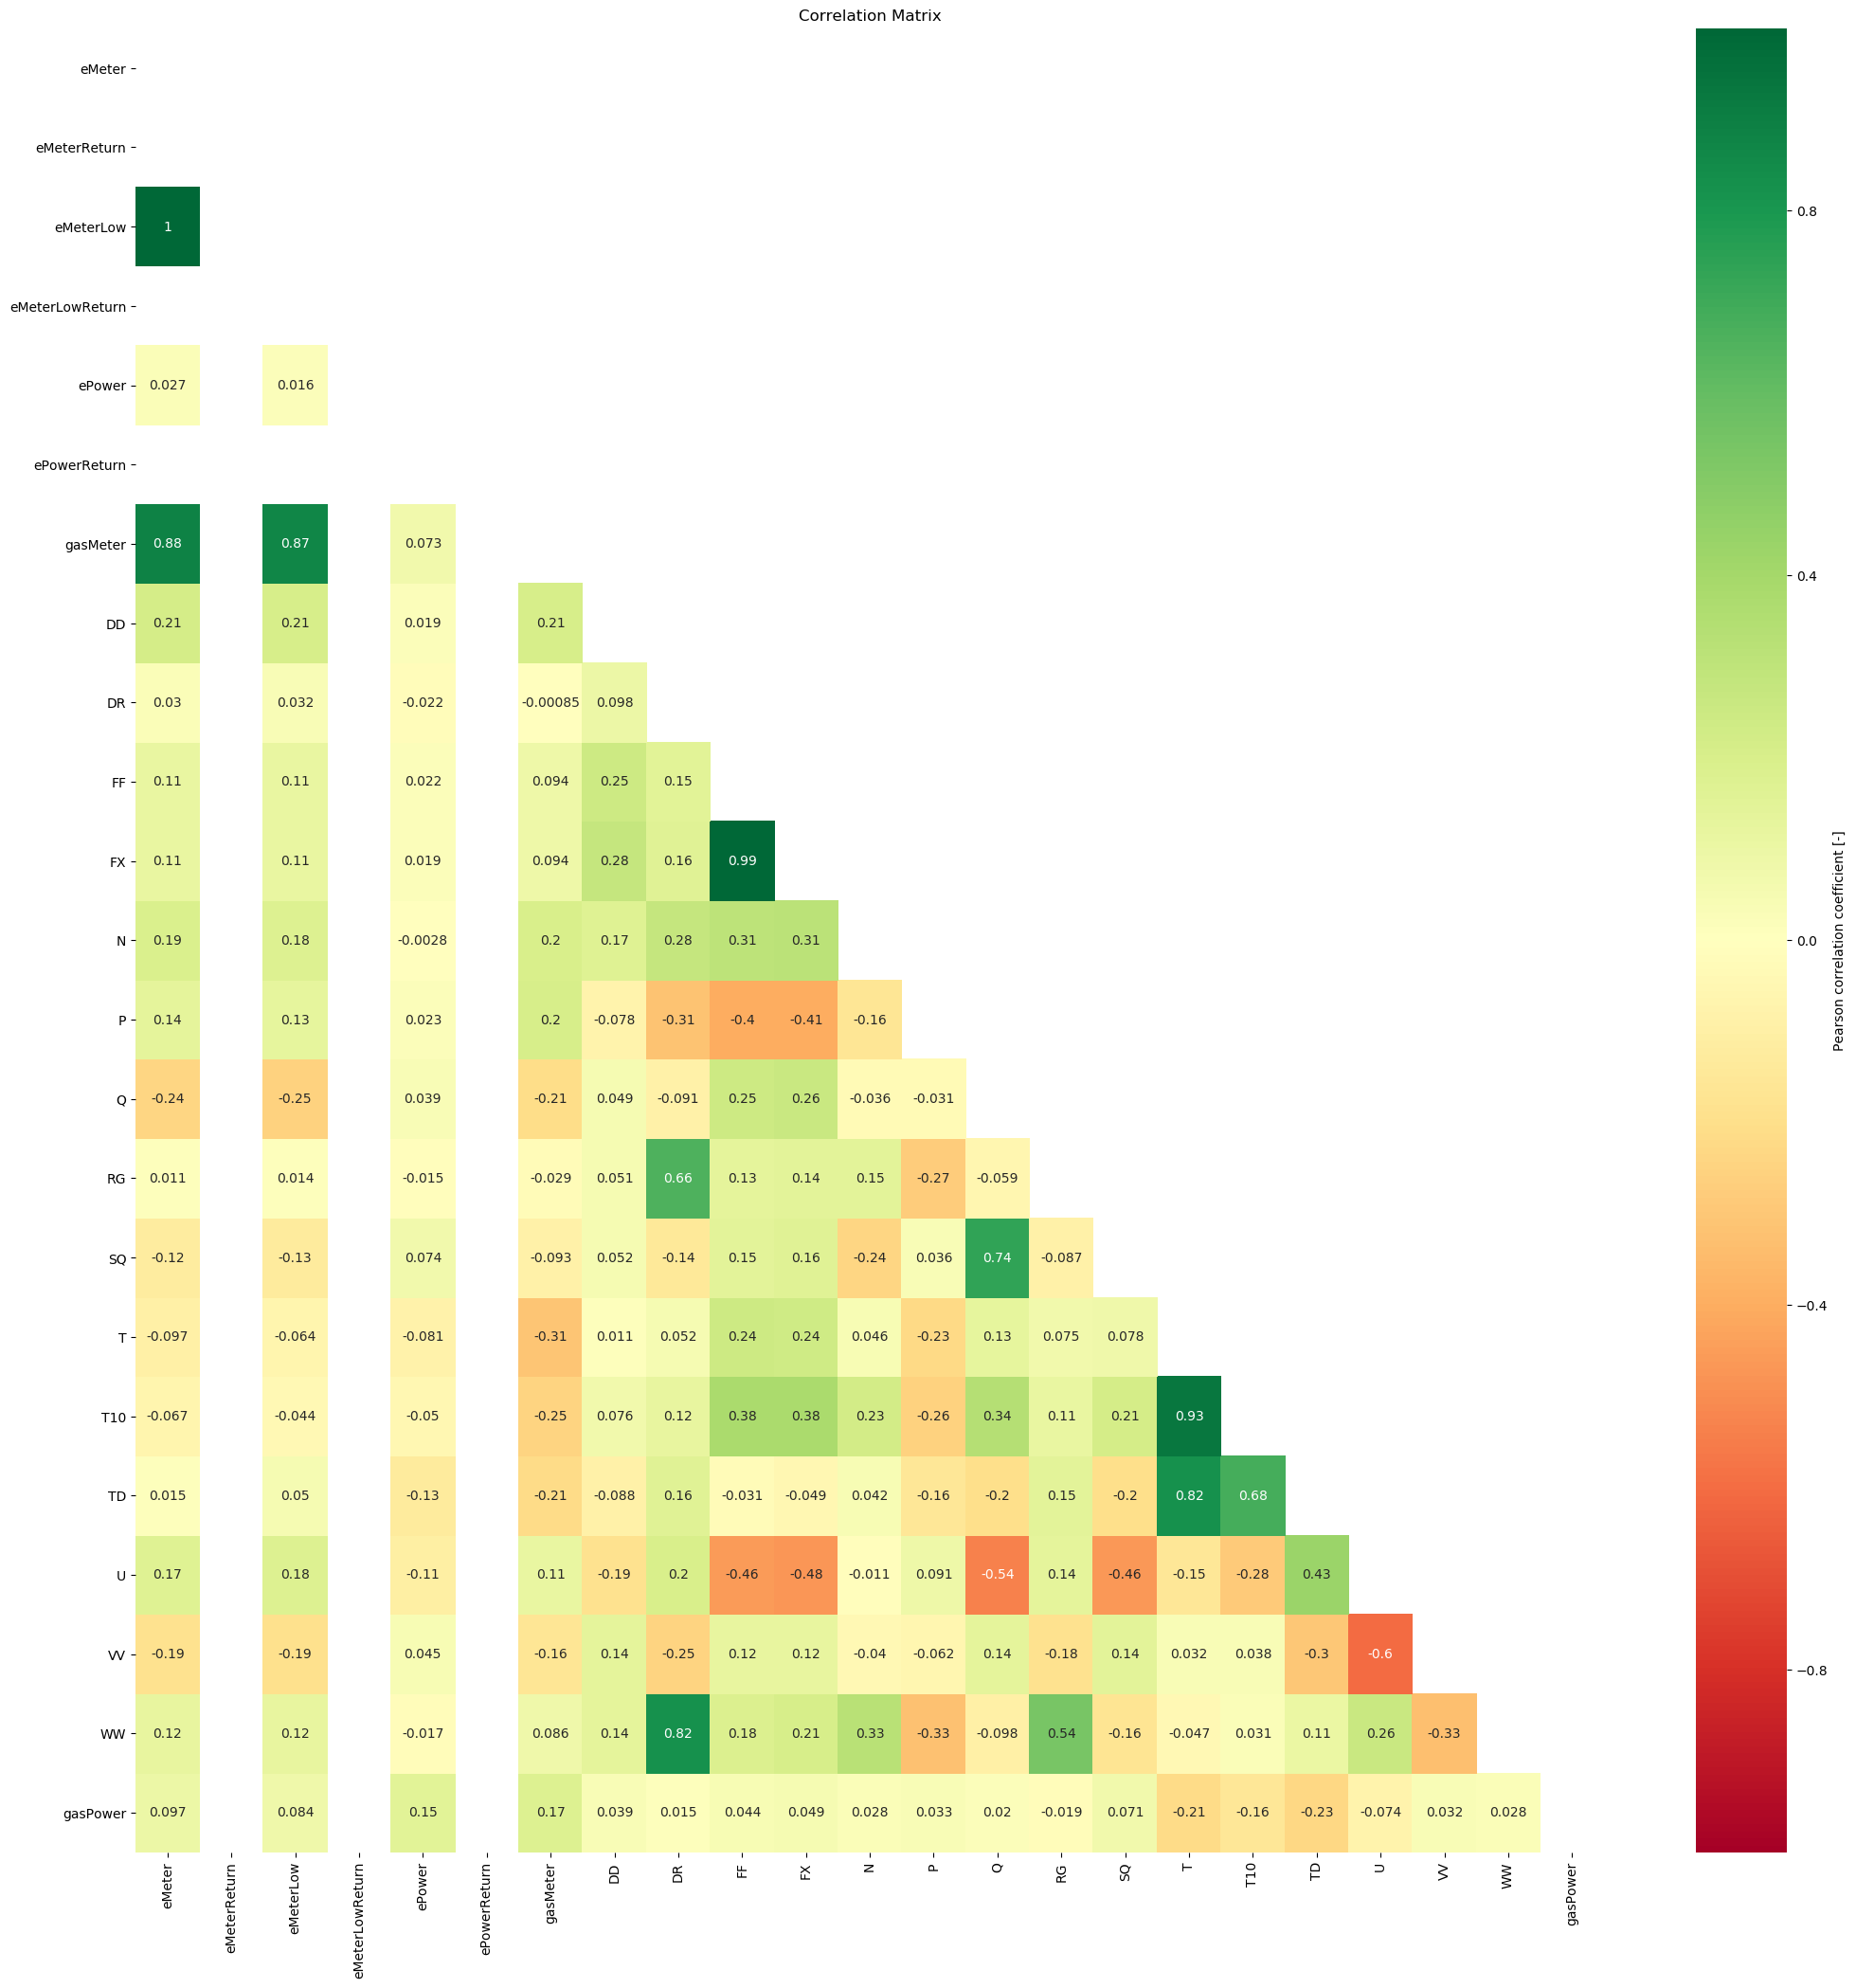

In [15]:
corr = rdftrain.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(25,25))

sns.heatmap(corr, mask=mask, square=False, cmap='RdYlGn', annot=True, ax=ax,
            cbar_kws={'label':'Pearson correlation coefficient [-]'})

plt.title('Correlation Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
#plt.savefig('sample.png', dpi=500)
plt.show()

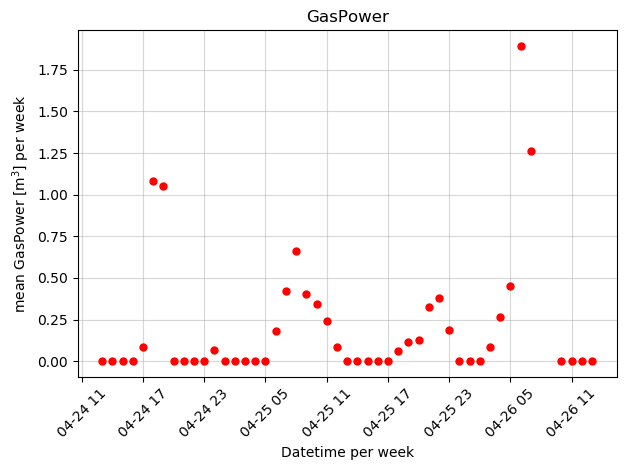

In [5]:
plt.title('GasPower')

plt.plot(rdf.index[:50],rdf['gasPower'][:50], '.', color='r', ms=10)
plt.ylabel('mean GasPower [m$^3$] per week')
plt.xlabel('Datetime per week')
plt.xticks(rotation=45)
plt.grid(alpha=0.5)
plt.tight_layout()

#plt.savefig('humanpatterns.png', dpi=700)

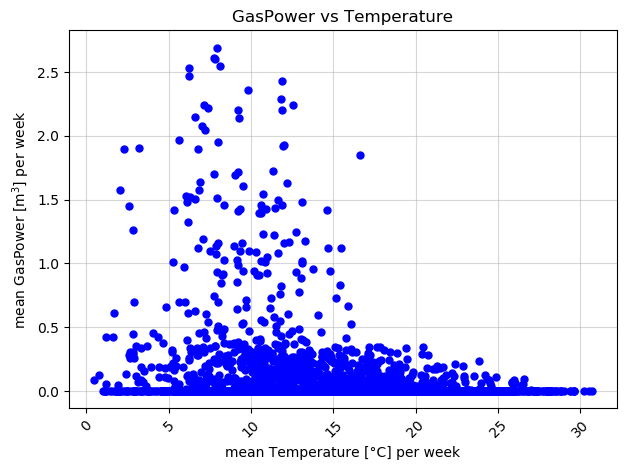

In [6]:
plt.title('GasPower vs Temperature')
plt.plot(rdf['T'][:],rdf['gasPower'][:], '.', color='b', ms=10)
# plt.plot(rdftrain['T'][:],rdftrain['gasPower'][:], '.', color='r', ms=10)

plt.ylabel('mean GasPower [m$^3$] per week')
plt.xlabel('mean Temperature [°C] per week')
plt.xticks(rotation=45)
plt.grid(alpha=0.5)
plt.tight_layout()

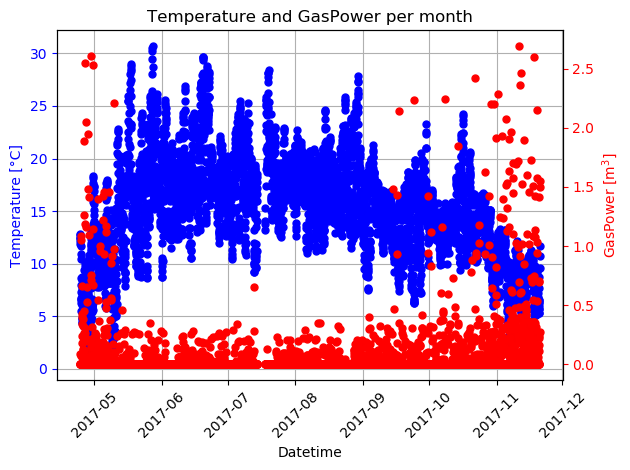

In [7]:
fig, ax1 = plt.subplots()
ax1.plot(rdf.index[:],rdf['T'][:], '.', color='b', ms=10)
plt.title('Temperature and GasPower per month')
ax1.set_xlabel('Datetime')
plt.xticks(rotation=45)
#Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Temperature [°C]', color='b')
ax1.tick_params('y', colors='b')
plt.grid()
fig.tight_layout()

ax2 = ax1.twinx()
ax2.plot(rdf.index[:],rdf['gasPower'][:], '.', color='r', ms=10)
ax2.set_ylabel('GasPower [m$^3$]', color='r')
ax2.tick_params('y', colors='r')
fig.tight_layout()

#plt.savefig('sample1mon.png', dpi=1000)
plt.show()

LinAlgError: SVD did not converge in Linear Least Squares

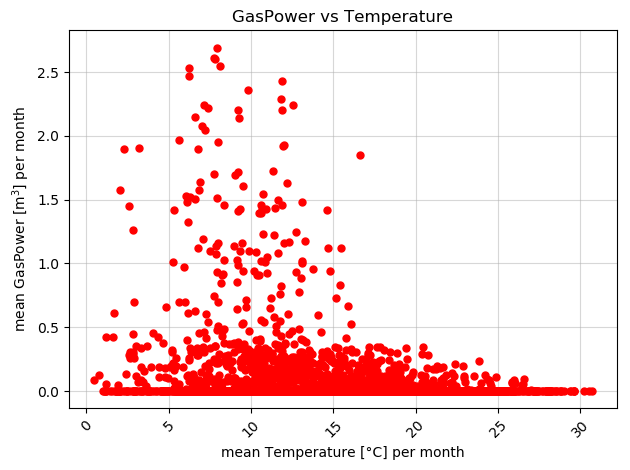

In [8]:
plt.title('GasPower vs Temperature')

plt.plot(rdf['T'][:],rdf['gasPower'][:], '.', color='r', ms=10)
plt.ylabel('mean GasPower [m$^3$] per month')
plt.xlabel('mean Temperature [°C] per month')
plt.xticks(rotation=45)
plt.grid(alpha=0.5)
plt.tight_layout()

# linear regressions
params = np.polyfit(rdftrain['T'],rdftrain['gasPower'], 1)
def model(x, a, b):
    return a * x + b

# Extrapolations
x = np.array([-10,20])
plt.plot(x, model(x, *params), 'k', alpha=0.9, linewidth=0.5)

plt.xlim(0,20)
plt.ylim(-0.05, 0.5)

#plt.savefig('gasvstemp1d.png', dpi=700)
print(params)

In [9]:
print(bias)

0.011586791036390178


In [10]:
print(params)

[-0.03272075  0.50891235]


In [30]:
def predict(T):
    prediction=list()
    for i in T:
        if i>16.5:
            gas=bias
        else:
            gas=params[0]*i+params[1]
            
    prediction.append(i)
    return prediction

In [32]:
T = rdf['T']
T

datetime
2017-04-30     8.045000
2017-05-07    10.954603
2017-05-14    12.257004
2017-05-21    16.438393
2017-05-28    18.320417
2017-06-04    17.960972
2017-06-11    16.908948
2017-06-18    18.285843
2017-06-25    20.704454
2017-07-02    16.943591
2017-07-09    18.867679
2017-07-16    16.573409
2017-07-23    19.737298
2017-07-30    17.708244
2017-08-06    17.706677
2017-08-13    16.651627
2017-08-20    17.307758
2017-08-27    18.239246
2017-09-03    16.512619
2017-09-10    15.840754
2017-09-17    13.071984
2017-09-24    13.276200
2017-10-01    14.684355
2017-10-08    13.526458
2017-10-15    14.676151
2017-10-22    14.641726
2017-10-29    13.302986
2017-11-05    10.124901
2017-11-12     6.842827
2017-11-19     7.857312
2017-11-26     7.047018
Freq: W-SUN, Name: T, dtype: float64

In [33]:
predict(T)

[7.04701757368421]